# Transfer Learning

The ImageNet-1K Classification task is the most influential of all classification tasks. There are 1000 different categories and the dataset has roughly 1 million training images. To train CNNs on ImageNet takes days or weeks usually.

To get a really good CNN, you need 10K-100K labeled images for training, minimum. But it turns out that we can actually take a really good ImageNet CNN and use it to extract features for a smaller dataset. Then we simply train a classifier on the features. Let's demonstrate.

## Example: Classify Bees vs Ants with ResNet-18

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
# Modified by Dylan Flaute

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


### Data

We have a dataset of ~120 ants and bees and 75 validation images for each class. This is a very small dataset!

Download the data from this link: https://download.pytorch.org/tutorial/hymenoptera_data.zip

Note this data comes from ImageNet, so we're kind of cheating, but it's fine.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.expanduser('~/Downloads/hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


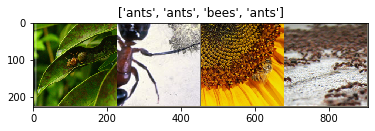

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


### Write a General Training Function

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    tic = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            toc = time.time()
            mins, secs = divmod(toc - tic, 60)
            print(f"Time elapsed: {int(mins):2d}m {secs:.0f}s")

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - tic
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Write a General Prediction Visualization Function

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


### Make the Model

In [6]:
blank_model = torchvision.models.resnet18()
print(blank_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()
        pretrained_model = torchvision.models.resnet18(pretrained=True)
        for param in pretrained_model.parameters():
            param.requires_grad = False
            
        self.feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])
        
        self.feature_vector_size = 512
        self.final_layer = nn.Linear(self.feature_vector_size, num_classes)
        
    def forward(self, x):
        feature_vector = self.feature_extractor(x)  # (B, F, 1, 1)
        feature_vector = feature_vector.squeeze(-1).squeeze(-1)  # (B, F)
        logits = self.final_layer(feature_vector)
        return logits

In [11]:
net = Network(2)
net = net.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(net.final_layer.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [16]:
net = train_model(net, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3429 Acc: 0.8689
Time elapsed:  0m 18s
val Loss: 0.2289 Acc: 0.9281
Time elapsed:  0m 27s

Epoch 1/24
----------
train Loss: 0.3172 Acc: 0.8566
Time elapsed:  0m 44s
val Loss: 0.1785 Acc: 0.9346
Time elapsed:  0m 53s

Epoch 2/24
----------
train Loss: 0.2726 Acc: 0.8852
Time elapsed:  1m 10s
val Loss: 0.1990 Acc: 0.9346
Time elapsed:  1m 18s

Epoch 3/24
----------
train Loss: 0.3696 Acc: 0.8320
Time elapsed:  1m 36s
val Loss: 0.1837 Acc: 0.9216
Time elapsed:  1m 44s

Epoch 4/24
----------
train Loss: 0.3310 Acc: 0.8484
Time elapsed:  2m 1s
val Loss: 0.1960 Acc: 0.9216
Time elapsed:  2m 10s

Epoch 5/24
----------
train Loss: 0.3612 Acc: 0.8566
Time elapsed:  2m 27s
val Loss: 0.2344 Acc: 0.9216
Time elapsed:  2m 35s

Epoch 6/24
----------
train Loss: 0.3265 Acc: 0.8484
Time elapsed:  2m 52s
val Loss: 0.2216 Acc: 0.9216
Time elapsed:  3m 1s

Epoch 7/24
----------
train Loss: 0.3304 Acc: 0.8525
Time elapsed:  3m 18s
val Loss: 0.1820 Acc: 0.9412
Time elap

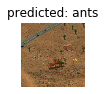

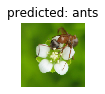

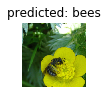

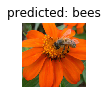

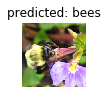

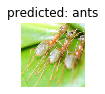

In [18]:
visualize_model(net)


## Takeaways

Transfer learning is a *vital* technique for computer vision. Transferring the power of ImageNet-pretrained CNNs to other problems has been revolutionary for the field. You learned how to do the "fixed feature extractor" variety of transfer learning, but it's also possible train the whole CNN. This is called "fine-tuning." The workflow is: You start with ImageNet-pretrained CNN weights. You replace the classifier with a fresh one. And you train the whole thing jointly with a very low learning rate so that you keep some of the "know-how" of the highly general ImageNet weights in the feature extraction process.

Figure out how to do that by following the tutorial I based this off of: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html